In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import openslide
from skimage.color import rgb2hsv
import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.utils.extmath import softmax

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax

In [2]:
from sklearn.utils.extmath import softmax
class RidgeClassifierProb(RidgeClassifier):
    def predict_proba(self, X):
        d = self.decision_function(X)
        d_2d = np.c_[-d, d]
        return softmax(d_2d)

In [3]:
hdf5_path = '/home/irene/Downloads/luadlusc.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()


<KeysViewHDF5 ['test_img', 'test_label', 'train_img', 'train_label', 'val_img', 'val_label']>

In [4]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)


In [5]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len



In [6]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("inception_v3", pretrained=True)


model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [8]:
iterator = iter(train_loader)
total_step = len(train_loader)
print(total_step)

3724


In [9]:
max_epochs = 20
def train_valid_model (net,loader):
    iterator = iter(train_loader)
    lfv_all = []
    label_all = []
    total_step = len(train_loader)
    total_step = total_step-3700
    for step in range(total_step-1):
        images,labels = next(iterator)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output,labels)

        lfv = model.forward_features(images)
        print(lfv.shape)
        print(labels.shape)
        if len(lfv_all) == 0:
            lfv_all = lfv.detach().cpu().numpy()
            label_all = labels.detach().cpu().numpy()
        else:
            lfv_all = np.vstack((lfv_all, lfv.detach().cpu().numpy()))
            label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
        
        print("Batch:")
        print(step)
    return lfv_all, label_all



In [10]:
max_epochs = 20
def test_valid_model (net,loader):
    iterator = iter(train_loader)
    lfv_all = []
    label_all = []
    total_step = len(train_loader)
    total_step = total_step-3700
    for step in range(total_step-1):
        images,labels = next(iterator)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output,labels)

        lfv = model.forward_features(images)
        print(lfv.shape)
        print(labels.shape)
        if len(lfv_all) == 0:
            lfv_all = lfv.detach().cpu().numpy()
            label_all = labels.detach().cpu().numpy()
        else:
            lfv_all = np.vstack((lfv_all, lfv.detach().cpu().numpy()))
            label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
        
        print("Batch:")
        print(step)
    return lfv_all, label_all

In [11]:
x_train,y_train = train_valid_model(model, train_loader)

y_train = y_train.flatten()

torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
0
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
1
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
2
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
3
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
4
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
5
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
6
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
7
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
8
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
9
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
10
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
11
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
12
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
13
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
14
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
15
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
16
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
17
torch.Size([8, 2048, 5, 5])
torch.Size

In [24]:
clf = CalibratedClassifierCV(LinearSVC())
#nsamples, l, nx, ny  = x_train.shape
x_train = x_train.reshape((nsamples,l*nx*ny))
clf.fit(x_train, y_train)
print("done-fitting!")

done-fitting!


In [31]:
clf = RidgeClassifierProb()
#nsamples, l, nx, ny  = x_train.shape
x_train = x_train.reshape((nsamples,l*nx*ny))
clf.fit(x_train, y_train)
print("done-fitting!")

done-fitting!


In [24]:
clf = LogisticRegression()
#nsamples, l, nx, ny  = x_train.shape
x_train = x_train.reshape((nsamples,l*nx*ny))
clf.fit(x_train, y_train)
print("done-fitting!")

done-fitting!


In [13]:
x_test, y_test = test_valid_model(model, test_loader)

y_test = y_test.flatten()

torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
0
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
1
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
2
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
3
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
4
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
5
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
6
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
7
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
8
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
9
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
10
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
11
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
12
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
13
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
14
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
15
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
16
torch.Size([8, 2048, 5, 5])
torch.Size([8])
Batch:
17
torch.Size([8, 2048, 5, 5])
torch.Size

In [25]:
#nsamples, l, nx, ny  = x_test.shape
x_test = x_test.reshape((nsamples,l*nx*ny))
y_pred = clf.predict(x_test)
print("done-predicting!")

done-predicting!


In [27]:
y_prob = clf.predict_proba(x_test)

In [27]:
d = clf.decision_function(x_test)[0]
y_prob = np.exp(d) / np.sum(np.exp(d))
print("done-predicting probability!")
fpr = dict()
tpr = dict()

done-predicting probability!


In [28]:
print(y_prob)

[[0.44524789 0.55475211]
 [0.3912444  0.6087556 ]
 [0.42977841 0.57022159]
 [0.47711727 0.52288273]
 [0.40894038 0.59105962]
 [0.45782461 0.54217539]
 [0.44516642 0.55483358]
 [0.42858682 0.57141318]
 [0.42241222 0.57758778]
 [0.47161944 0.52838056]
 [0.38204387 0.61795613]
 [0.48497831 0.51502169]
 [0.45879621 0.54120379]
 [0.4043332  0.5956668 ]
 [0.32935044 0.67064956]
 [0.47004123 0.52995877]
 [0.44197914 0.55802086]
 [0.51514275 0.48485725]
 [0.43272577 0.56727423]
 [0.48010336 0.51989664]
 [0.39376704 0.60623296]
 [0.45417426 0.54582574]
 [0.40043314 0.59956686]
 [0.40104392 0.59895608]
 [0.47533034 0.52466966]
 [0.50490779 0.49509221]
 [0.38923953 0.61076047]
 [0.36482131 0.63517869]
 [0.41670045 0.58329955]
 [0.49992576 0.50007424]
 [0.43622755 0.56377245]
 [0.46975474 0.53024526]
 [0.42928355 0.57071645]
 [0.42148102 0.57851898]
 [0.40950507 0.59049493]
 [0.41689319 0.58310681]
 [0.46792678 0.53207322]
 [0.37737973 0.62262027]
 [0.42575055 0.57424945]
 [0.46958147 0.53041853]


AUC: 0.587


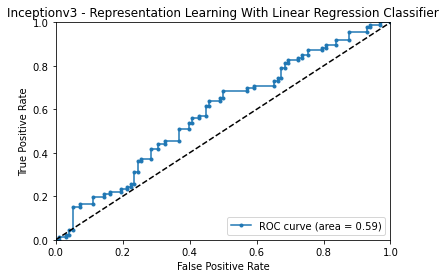

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
roc_auc = roc_auc_score(y_test, y_prob[:,1])
print('AUC: %.3f' % roc_auc)
# ROC Curves and AUC
plt.plot(fpr,tpr ,marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Inceptionv3 - Representation Learning With Linear Regression Classifier')
plt.legend(loc="lower right")
plt.savefig('Inceptionv3_Representation_Learning_lr.png')

In [29]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)
print(accuracy)
f1 = f1_score(y_test, y_pred)
print(f1)

0.5869565217391305
0.638095238095238
